# Week 6 - Classification models  

## Part 2: Travel mode choice - Logistic regression

In this part we will consider a real world problem with discrete target variables (y): travel model choice. The goal is to model the travel mode choices (plane, train, bus or car) based on trip characteristics (features) like the terminal waiting time, cost, travel time, etc. We shall start by using a logistic regression model for this.

The usual imports...

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Before we go to the modelling part, we need to prepare the data, which consists of a record of travel choices for a total of 80 individuals. 

Lets load the data using pandas:

In [3]:
# load csv
df = pd.read_csv("modechoice_data.csv")
df.head()

,Unnamed: 0,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
0,0,70.0,30.0,4.0,10.0,61.0,80.0,73.0,44.0,24.0,350.0,77.0,53.0,19.0,395.0,79.0,4.0,314.0,52.0,1.0
1,1,8.0,15.0,4.0,64.0,48.0,154.0,71.0,55.0,25.0,360.0,80.0,53.0,14.0,462.0,84.0,4.0,351.0,57.0,2.0
2,2,62.0,35.0,2.0,64.0,58.0,74.0,69.0,30.0,21.0,295.0,66.0,53.0,24.0,389.0,83.0,7.0,315.0,55.0,2.0
3,3,61.0,40.0,3.0,45.0,75.0,75.0,96.0,44.0,33.0,418.0,96.0,53.0,28.0,463.0,98.0,5.0,291.0,49.0,1.0
4,4,27.0,70.0,1.0,20.0,106.0,190.0,127.0,34.0,72.0,659.0,143.0,35.0,33.0,653.0,104.0,44.0,592.0,108.0,1.0


The mode is encoded as a integer from 1 to 4, corresponding to:
- 1 - plane
- 2 - train
- 3 - bus
- 4 - car

Some basic data statistics:

Dataset size: 394


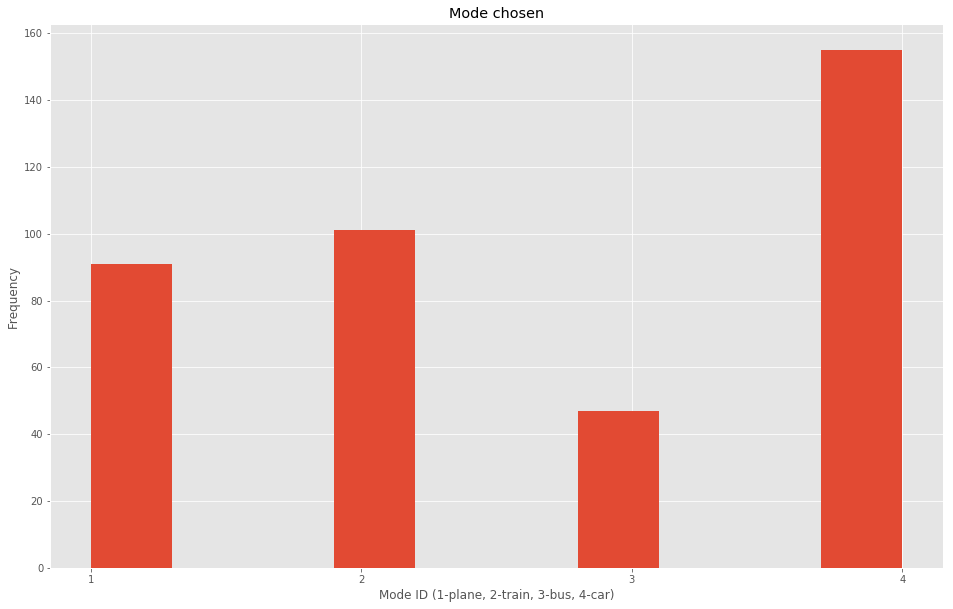

In [4]:
print("Dataset size:", len(df))
df['mode_chosen'].hist();
plt.title('Mode chosen')
plt.xlabel('Mode ID (1-plane, 2-train, 3-bus, 4-car)')
plt.ylabel('Frequency')
plt.xticks([1,2,3,4]);

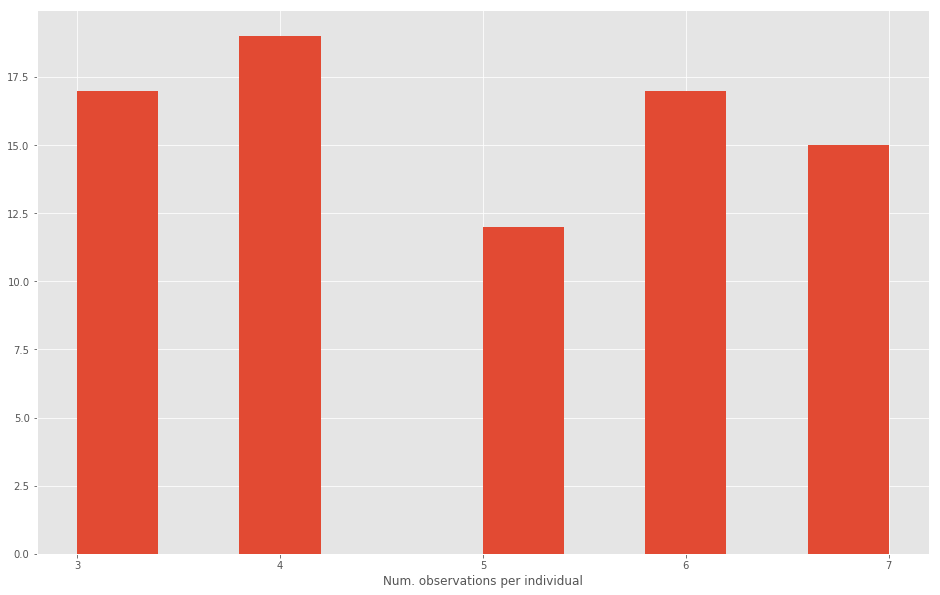

In [5]:
plt.hist(df.groupby("individual").count()["mode_chosen"])
plt.xticks(np.unique(df.groupby("individual").count()))
plt.xlabel('Num. observations per individual');

In [6]:
# more statistics
df.describe()

,Unnamed: 0,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,196.500000,39.032995,34.228426,1.761421,61.215736,83.350254,132.005076,100.510152,35.685279,49.832487,597.847716,127.101523,42.000000,33.073604,624.718274,114.065990,21.101523,565.667513,94.170051,2.675127
std,113.882249,22.816704,19.276048,1.030790,15.780674,26.625461,45.484891,29.081987,12.712417,26.727488,245.826336,55.855820,11.962409,12.787644,233.524090,43.468285,15.164236,263.027420,44.398771,1.213176
min,0.000000,1.000000,2.000000,1.000000,5.000000,44.000000,63.000000,56.000000,1.000000,11.000000,255.000000,42.000000,5.000000,12.000000,227.000000,45.000000,2.000000,180.000000,32.000000,1.000000
25%,98.250000,19.250000,18.000000,1.000000,64.000000,59.250000,95.750000,72.000000,34.000000,30.000000,357.000000,74.000000,35.000000,25.000000,406.000000,73.000000,10.000000,315.000000,52.000000,2.000000
50%,196.500000,39.000000,35.000000,1.000000,64.000000,81.000000,125.000000,96.000000,34.000000,36.000000,602.000000,119.000000,35.000000,31.000000,599.000000,105.000000,16.000000,577.000000,96.000000,3.000000
75%,294.750000,57.750000,45.000000,2.000000,69.000000,105.000000,158.000000,125.000000,44.000000,72.000000,873.000000,177.000000,53.000000,44.000000,870.000000,145.000000,31.500000,858.000000,135.000000,4.000000
max,393.000000,80.000000,72.000000,6.000000,90.000000,180.000000,333.000000,197.000000,99.000000,111.000000,1104.000000,269.000000,60.000000,70.000000,1110.000000,222.000000,86.000000,1440.000000,228.000000,4.000000


Lets now preprocess the data by:
- Separating the inputs (x) from the targets (y)
- Standardizing the input variables in order to have zero mean and unit standard deviation

In [7]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.values
X = mat[:,2:-1]
print(X.shape)  
y = mat[:,-1].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")  #and get the indexes
print(ind.shape)

(394, 17)
(394,)
(394,)


In [8]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

The next step is to split our data into a train and test set. Alternatively, we could have used something like cross-validation, but for the sake of simplicity, a train/test split will do just fine for this example.

In [9]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 260
num test: 134


Just for the sake of comparision (and for fun!), lets run logistic regression from the popular sklearn package.

In [10]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 4 1 4 4 4 3 1 4 2 1 4 2 1 4 4 4 4 4 2 4 1 4 1 2 4 4 4 2 3 4 4
 3 2 4 4 4 2 2 2 4 1 3 2 3 1 2 4 1 1 4 2 4 4 1 3 2 4 2 4 4 4 3 2 3 2 4 2 4
 4 4 1 4 2 2 4 4 1 4 3 4 4 2 1 4 3 1 4 2 1 4 1 4 4 4 1 1 2 1 3 2 4 4 4 4 4
 4 4 1 3 3 1 4 3 2 4 1 4 2 1 3 2 2 2 4 4 4 4 2]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.6194029850746269


Ok, time to do it in STAN!

Since we don't have a column in the inputs (X) that is always equal to 1, we need to incorporate the bias term in our model explicitly. Hence, we shall include an extra set of bias parameters $\boldsymbol\alpha = \{\alpha_1,\dots,\alpha_C\}$ in the model. The likelihood is then of the form:

\begin{align}
y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\boldsymbol\alpha + \textbf{B} \textbf{x}_n^T))
\end{align}

where $\textbf{B} = (\boldsymbol\beta_1,\dots,\boldsymbol\beta_C)^T$

Remember that STAN expects the targets $y_n$ as integers in {1,2,3,4}!

Your turn now :-) Can you implement it in STAN?

In [11]:
# define Stan model
model_definition = """
data {
  int<lower=0> N;    // shape of data
  int<lower=0> D;    // dimensions of x
  int<lower=0> C;    // number of possible choices
  matrix[N,D]  X;    // feature matrix
  int          y[N]; // response vector
}
parameters {
  vector[C]    alpha; // bias of each choice
  matrix[C, D] beta;  // parameters
}
model{
  matrix[N, C] z;

  for (c in 1:C){
    z = alpha[c] + X*beta';  
  }
  
  to_vector(beta) ~ normal(0,5);
  alpha  ~ normal(0., 5);
  
  for (n in 1:N){
    y[n] ~ categorical_logit(z[n]');  
  }
}
"""

# compile model
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_029f7c4accf253a0d9d9a2fcd0a49dcb NOW.


In [12]:
# prepare data for Stan model
N, D = X_train.shape
C = len(np.unique(y_train))
print("N=%d, D=%d, C=%d" % (N,D,C))
data = {'N': N, 'D': D, 'C': C, 'X': X_train, 'y': y_train}

N=260, D=17, C=4


Compile the model and run inference using ADVI:

In [13]:
%%time
# create Stan model object
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

CPU times: user 1.74 s, sys: 4.29 ms, total: 1.74 s
Wall time: 1.73 s


Plot posterior distributions for the parameters using our "pystan_utils" library:

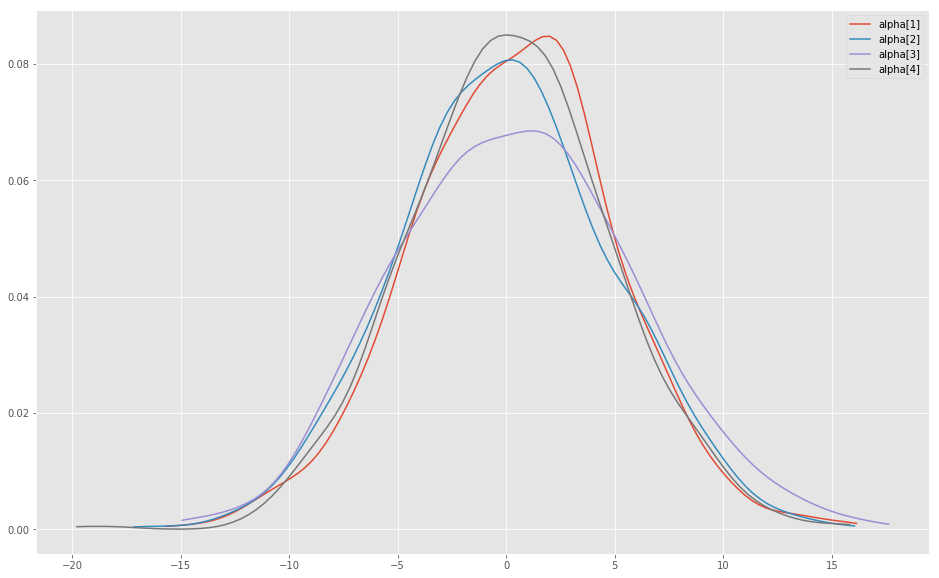

In [14]:
# posteriors over alpha
pystan_utils.vb_plot_variables(fit, "alpha")

In [1]:
# posteriors over weights for class 1
pystan_utils.vb_plot_variables(fit, "beta[1")

NameError: name 'pystan_utils' is not defined

We can now use the inferred posteriors to make predictions. Lets first use the "pystan_utils" package to extract the expected values of the posterior distribution of the model parameters:

In [16]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

We can then use these values to make predictions for the testset and compute the corresponding accuracy:

In [17]:
# make predictions for test set
y_hat = alpha[:,np.newaxis] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 1 1 2 4 4 3 1 2 2 1 1 2 1 2 4 1 1 4 2 1 1 1 1 2 4 4 4 2 3 4 1
 3 2 1 4 4 2 2 2 1 1 3 2 3 1 2 4 1 1 1 2 4 1 1 4 2 4 2 4 4 2 3 2 1 2 4 2 4
 4 4 1 4 2 2 4 4 1 4 4 4 4 3 1 1 3 1 4 2 1 4 1 1 4 1 1 4 2 1 3 2 4 1 4 1 4
 1 3 1 3 1 1 4 3 2 1 1 4 2 1 1 2 2 2 1 4 4 1 2]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.6417910447761194


You should have obtained a similar accuracy to sklearn...

However, you now have full posterior distributions for the model parameters. Therefore, you can see how each trip characteristic affects the travel mode choices, but also how uncertain the model is about that relationship. For example, a very wide posterior distribution of a coefficient $\beta$ around 3, would tell you that, on average, the corresponding variables contributes positively to a having preference for a given mode, but the model is not very confident about that conclusion.